In [1]:
# Build Recurrent Neural Net Learning Machine (RNNLM) via model specified in https://arxiv.org/pdf/1901.03860.pdf

In [2]:
import numpy as np
import tenncor as tc
import librosa
import librosa.display

In [3]:
y, sr = librosa.load(librosa.util.example_audio_file())
melout = librosa.feature.melspectrogram(y=y, sr=sr)

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(melout, ref=np.max)
librosa.display.specshow(S_dB, 
    x_axis='time',
    y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 2 Axes>

In [5]:
weight_init = lambda shape, label: \
    tc.variable(np.random.uniform(-0.05, 0.05, shape.as_list()), label)

melin = tc.EVariable(list(melout.shape), label="melin")
ftinput = tc.api.permute(melin, [2, 0, 1])
finetuned = tc.api.layer.link([
    tc.api.layer.conv([5, 5], 1, 1,
                  weight_init=tc.api.layer.norm_xavier_init(0.5),
                  zero_padding=((2, 2), (2, 2))), 
    tc.api.layer.conv([5, 5], 1, 1,
                  weight_init=tc.api.layer.norm_xavier_init(0.5),
                  zero_padding=((2, 2), (2, 2))), 
    tc.api.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
                 weight_init=weight_init,
                 seq_dim=2),
    tc.api.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
                 weight_init=weight_init,
                 seq_dim=2),
    tc.api.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
                 weight_init=weight_init,
                 seq_dim=2),
    tc.api.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
                 weight_init=weight_init,
                 seq_dim=2),
    tc.api.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
                 weight_init=weight_init,
                 seq_dim=2),
    tc.api.layer.conv([2, 2], 1, 1,
                  weight_init=tc.api.layer.norm_xavier_init(0.5),
                  zero_padding=((0, 1), (0, 1))), # lookahead conv
], ftinput)
fineout = tc.api.permute(finetuned, [1, 2, 0])
print(melin.shape())
print(fineout.shape())

[ 128 2647]
[ 128 2647]


In [6]:
nkeywords = 11
keyword_model = tc.api.layer.link([
    finetuned,
    tc.api.layer.lstm(tc.Shape([melout.shape[1], 1]), 1, 128,
                  weight_init=weight_init,
                  seq_dim=2),
    tc.api.layer.dense(list(melout.shape) + [1], [nkeywords],
                   weight_init=weight_init,
                   dims = [(0, 0), (1, 1), (2, 2)])
])
keyword_prob = tc.api.softmax(keyword_model, 0, 1)
print(finetuned.shape())
print(keyword_prob.shape())

[ 128 2647    1]
[11]


In [7]:
tc.optimize('cfg/optimizations.json')

In [8]:
melin.assign(melout)

[[ 8.26842061e-09  7.21067606e-09  4.64097782e-09 ...  1.08708314e-16
   7.57627667e-16 -1.63364465e-16]
 [ 1.17612302e-08  6.98931890e-09  5.39505018e-09 ...  1.07484908e-17
   1.04147804e-15 -2.82628107e-16]
 [ 1.15383525e-08  2.69042122e-09  1.93132021e-09 ... -7.21462430e-17
   1.06436148e-15 -3.34087556e-16]
 ...
 [-5.60835016e-14 -3.06540248e-13 -2.22076318e-13 ...  4.05830137e-19
  -4.05185272e-19  5.22497132e-20]
 [-6.01977574e-14 -2.86177820e-13 -1.79538052e-13 ...  3.08124907e-19
  -4.01370574e-19  6.50691741e-20]
 [ 1.96733126e-14  1.81700819e-13  2.26285394e-13 ... -3.27848305e-19
   3.29647468e-20  2.69771483e-20]]


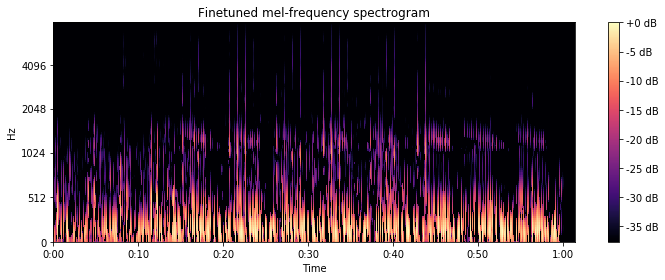

In [9]:
ftout = fineout.get()
ckpt = fineout.get_version()
print(ftout)
plt.figure(figsize=(10, 4))
S_dB2 = librosa.power_to_db(ftout, ref=np.max)
librosa.display.specshow(S_dB2, 
    x_axis='time',
    y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Finetuned mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [10]:
print(keyword_model.get(ckpt))
print(keyword_prob.get(ckpt))

[ 2.3179449e-09  3.6033443e-09 -1.3710083e-08  4.6624500e-09
  6.5967165e-09 -1.7698303e-08 -2.9037657e-09  1.5263062e-08
 -1.1476334e-08 -6.1152583e-11 -2.8777363e-08]
[0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
